In [325]:
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy
from collections import defaultdict
import dateutil.parser
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [326]:
# reading in just 1 file

def MTA_file_reader():
    '''
    scrape data from MTA website
    '''
    week_nums = [170624]
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    
    df = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        df.append(pd.read_csv(file_url))
    return pd.concat(df)

df = MTA_file_reader()

In [327]:
# rename columns due to spaces around strings

df.columns = [column.strip() for column in df.columns]

In [328]:
# create a KEY column
# create a DATETIME column as datetime object
# transform DATE column into datetime object
# drop duplicates


df['KEY'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP'] + ' ' + df['STATION']
df['DATETIME'] = pd.to_datetime(df.DATE.astype(str) + " " + df.TIME, format = "%m/%d/%Y %H:%M:%S")
df['DATE'] = pd.Series(map(lambda x : datetime.datetime.strptime(x, '%m/%d/%Y'), df.DATE))
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

In [329]:
# transform DataFrame into dict first

dd = defaultdict(list)
for index, row in df.iterrows():
    dd[row['KEY']].append([row['DATETIME'],row['ENTRIES']])

In [330]:
# for iteration purposes
ddIterate = deepcopy(dd)

In [331]:
# because turnstiles can get reset, we want to avoid negative hourly counts of entries when differencing
def current_entry(nextEntries, thisEntries, threshold):
    '''
    nextEntries, thisEntries : integers (cumulative entries up to this point in time)
    threshold : int (maximum value allowed for positive values)
    return: the appropriate amount of entries of a given point in time by taking the differences 
    '''
    entries_diff = nextEntries - thisEntries
    if entries_diff < 0:
        entries_diff = -entries_diff
    
    # if the turning the difference to positive is still too large, just set it to 0
    if entries_diff > threshold:
        return 0
    
    return entries_diff
        

In [332]:
# hourly entries in dict format
for key, value in ddIterate.items(): # for every turnstile
    for i in range(len(value) - 1):
        # difference between the next n hour's entries and current's
        currentEntry = current_entry(value[i+1][1], value[i][1], 100000)
        dd[key][i][1] = currentEntry # replace orginal dict entry data with the difference
    delete = dd[key].pop() # delete last obs for every key because no next obs
    
# take a look at the first key value pair in dd
dict(list(dd.items())[0:1])

{'A002 R051 02-00-00 59 ST': [[Timestamp('2017-06-17 00:00:00'), 34],
  [Timestamp('2017-06-17 04:00:00'), 35],
  [Timestamp('2017-06-17 08:00:00'), 120],
  [Timestamp('2017-06-17 12:00:00'), 243],
  [Timestamp('2017-06-17 16:00:00'), 300],
  [Timestamp('2017-06-17 20:00:00'), 168],
  [Timestamp('2017-06-18 00:00:00'), 25],
  [Timestamp('2017-06-18 04:00:00'), 21],
  [Timestamp('2017-06-18 08:00:00'), 117],
  [Timestamp('2017-06-18 12:00:00'), 184],
  [Timestamp('2017-06-18 16:00:00'), 232],
  [Timestamp('2017-06-18 20:00:00'), 112],
  [Timestamp('2017-06-19 00:00:00'), 6],
  [Timestamp('2017-06-19 04:00:00'), 47],
  [Timestamp('2017-06-19 08:00:00'), 165],
  [Timestamp('2017-06-19 12:00:00'), 281],
  [Timestamp('2017-06-19 16:00:00'), 705],
  [Timestamp('2017-06-19 20:00:00'), 159],
  [Timestamp('2017-06-20 00:00:00'), 15],
  [Timestamp('2017-06-20 04:00:00'), 52],
  [Timestamp('2017-06-20 08:00:00'), 164],
  [Timestamp('2017-06-20 12:00:00'), 294],
  [Timestamp('2017-06-20 16:00:00')

In [333]:
# hourly entries in Pandas DataFrame format
hourlyEntries = []
for key, values in dd.items():
    for value in values:
        hourlyEntries.append([key, value[0], value[1]])

hourlyEntriesDF = pd.DataFrame(np.array(hourlyEntries)
                               .reshape(len(hourlyEntries), 3), columns = ['KEY', 'DATETIME', 'nHOUR_ENTRIES'])
hourlyEntriesDF.head()

,KEY,DATETIME,nHOUR_ENTRIES
0,A002 R051 02-00-00 59 ST,2017-06-17 00:00:00,34
1,A002 R051 02-00-00 59 ST,2017-06-17 04:00:00,35
2,A002 R051 02-00-00 59 ST,2017-06-17 08:00:00,120
3,A002 R051 02-00-00 59 ST,2017-06-17 12:00:00,243
4,A002 R051 02-00-00 59 ST,2017-06-17 16:00:00,300


In [334]:
# transform dataframe into dict first ordered by KEY and DATE
dd2 = defaultdict(list)
for index, row in df.iterrows():
    dd2[(row['KEY'], row['DATE'])].append(row['ENTRIES'])

In [335]:
# for iteration purposes
ddIterate2 = deepcopy(dd2)

In [336]:
# daily entries in dict format
for key, values in ddIterate2.items():
    daily = current_entry(values[-1], values[0], 100000)
    dd2[(key[0],key[1])] = [daily]

# take a look at the first couple key value pair in dd2
dict(list(dd2.items())[0:10])

{('A002 R051 02-00-00 59 ST', Timestamp('2017-06-17 00:00:00')): [732],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-18 00:00:00')): [579],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-19 00:00:00')): [1204],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-20 00:00:00')): [1348],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-21 00:00:00')): [1250],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-22 00:00:00')): [1164],
 ('A002 R051 02-00-00 59 ST', Timestamp('2017-06-23 00:00:00')): [1316],
 ('A002 R051 02-00-01 59 ST', Timestamp('2017-06-17 00:00:00')): [670],
 ('A002 R051 02-00-01 59 ST', Timestamp('2017-06-18 00:00:00')): [509],
 ('A002 R051 02-00-01 59 ST', Timestamp('2017-06-19 00:00:00')): [970]}

In [337]:
# daily entries in Pandas DataFrame format
dailyEntries = []
for key, value in dd2.items():
        dailyEntries.append([key[0], key[1].date(), value[0]])

dailyEntriesDF = pd.DataFrame(np.array(dailyEntries)
                               .reshape(len(dailyEntries), 3), columns = ['KEY', 'DATE', 'DAILY_ENTRIES'])

dailyEntriesDF.head()

,KEY,DATE,DAILY_ENTRIES
0,A002 R051 02-00-00 59 ST,2017-06-17,732
1,A002 R051 02-00-00 59 ST,2017-06-18,579
2,A002 R051 02-00-00 59 ST,2017-06-19,1204
3,A002 R051 02-00-00 59 ST,2017-06-20,1348
4,A002 R051 02-00-00 59 ST,2017-06-21,1250


In [338]:
# adding STATION and WEEKDAY columns. DAILY_ENTRIES column also needs to be casted back to int type

dailyEntriesDF['STATION'] = pd.Series(map(lambda x : ' '.join(x.split(' ')[3:]), dailyEntriesDF['KEY']))
dailyEntriesDF['WEEKDAY'] = pd.Series(map(lambda x : x.weekday(), dailyEntriesDF['DATE']))
dailyEntriesDF['DAILY_ENTRIES'] = dailyEntriesDF['DAILY_ENTRIES'].astype(int) 
dailyEntriesDF.head()

,KEY,DATE,DAILY_ENTRIES,STATION,WEEKDAY
0,A002 R051 02-00-00 59 ST,2017-06-17,732,59 ST,5
1,A002 R051 02-00-00 59 ST,2017-06-18,579,59 ST,6
2,A002 R051 02-00-00 59 ST,2017-06-19,1204,59 ST,0
3,A002 R051 02-00-00 59 ST,2017-06-20,1348,59 ST,1
4,A002 R051 02-00-00 59 ST,2017-06-21,1250,59 ST,2


In [339]:
# some visualizations for analysis purposes

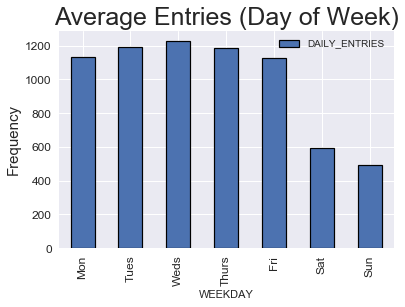

In [340]:
# weekday averages

weekdays = ['Mon', 'Tues', 'Weds','Thurs','Fri','Sat','Sun']

ax = (dailyEntriesDF
        .groupby(['WEEKDAY'])
        .mean()
        .plot(kind = 'bar',edgecolor='black', linewidth=1.2))

ax.set_title('Average Entries (Day of Week)', fontsize = 25,) 
ax.set_xticklabels(weekdays)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(labelsize=12)

In [341]:
# adding STATION and TIME columns. nHOUT_ENTRIES column need to be casted back to int type
hourlyEntriesDF['STATION'] = pd.Series(map(lambda x : x[19:], hourlyEntriesDF['KEY']))
hourlyEntriesDF['TIME'] = pd.Series(map(lambda x : str(x)[11:], hourlyEntriesDF['DATETIME']))
# hourlyEntriesDF['nHOUR_ENTRIES'] = pd.Series(map(lambda x : int(x), hourlyEntriesDF['nHOUR_ENTRIES']))
hourlyEntriesDF.nHOUR_ENTRIES = hourlyEntriesDF.nHOUR_ENTRIES.astype(int)

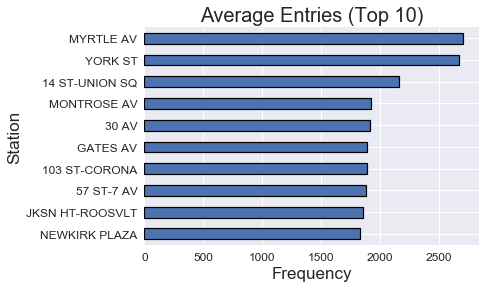

In [342]:
perStation = (dailyEntriesDF
                .groupby(['STATION'])
                .DAILY_ENTRIES
                .mean())

ax2 = (perStation
       .sort_values(ascending=False)
       .head(10)
       .sort_values()
       .plot(kind = 'barh',edgecolor='black', linewidth=1.2))

ax2.set_title('Average Entries (Top 10)', fontsize = 20) 
ax2.set_xlabel('Frequency', fontsize = 17)
ax2.set_ylabel('Station', fontsize = 17)
ax2.tick_params(labelsize=12)

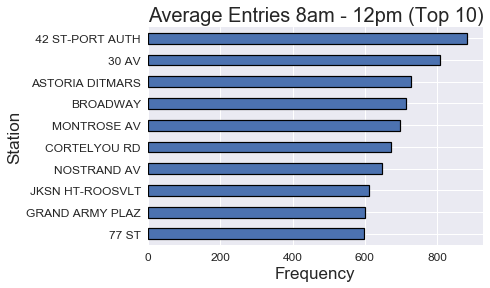

In [343]:
perStation8_12 = (hourlyEntriesDF[(hourlyEntriesDF['TIME'] == '08:00:00') & 
                                  (hourlyEntriesDF['STATION'] != ' TWENTY THIRD ST')]
                  .groupby('STATION')
                  .nHOUR_ENTRIES
                  .mean())

ax3 = (perStation8_12
       .sort_values(ascending=False)
       .head(10)
       .sort_values()
       .head(10)
       .plot(kind = 'barh',edgecolor='black', linewidth=1.2))

ax3.set_title('Average Entries 8am - 12pm (Top 10)', fontsize=20)
ax3.set_xlabel('Frequency', fontsize = 17)
ax3.set_ylabel('Station', fontsize = 17)
ax3.tick_params(labelsize=12)

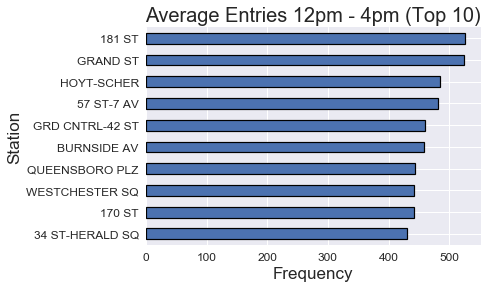

In [344]:
perStation12_16 = (hourlyEntriesDF[hourlyEntriesDF['TIME'] == '12:00:00']
                   .groupby('STATION')
                   .nHOUR_ENTRIES
                   .mean())

ax4 = (perStation12_16
       .sort_values(ascending=False)
       .head(10)
       .sort_values()
       .plot(kind = 'barh',edgecolor='black', linewidth=1.2))

ax4.set_title('Average Entries 12pm - 4pm (Top 10)', fontsize=20)
ax4.set_xlabel('Frequency', fontsize = 17)
ax4.set_ylabel('Station', fontsize = 17)
ax4.tick_params(labelsize=12)

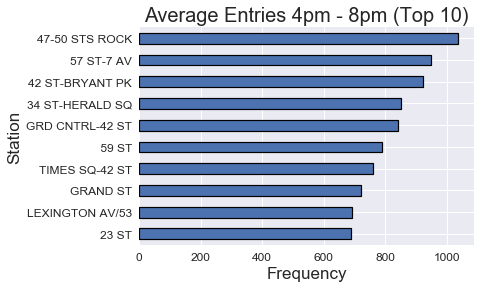

In [345]:
perStation16_20 = (hourlyEntriesDF[hourlyEntriesDF['TIME'] == '16:00:00']
                   .groupby('STATION')
                   .nHOUR_ENTRIES
                   .mean())

ax5 = (perStation16_20
       .sort_values(ascending=False)
       .head(10)
       .sort_values()
       .plot(kind = 'barh', edgecolor='black', linewidth=1.2))

ax5.set_title('Average Entries 4pm - 8pm (Top 10)', fontsize=20,)
ax5.set_xlabel('Frequency', fontsize = 17)
ax5.set_ylabel('Station', fontsize = 17)
ax5.tick_params(labelsize=12)

In [346]:
# lets make sure all entries have standardized time, otherwise plot by time will be messy!

standardizedTime = ['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00']
hourlyEntriesDF = hourlyEntriesDF[hourlyEntriesDF['TIME'].isin(standardizedTime)]

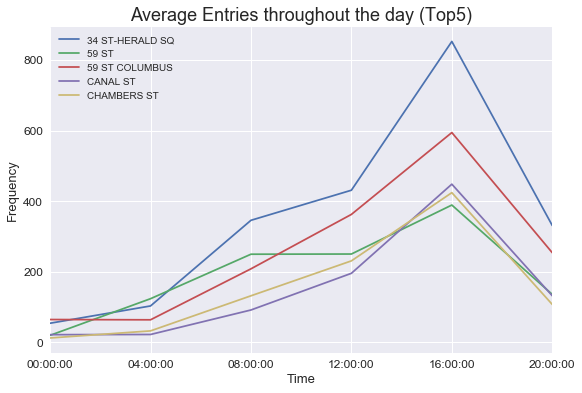

In [353]:
# Lets take a look at these stations
top5 = ['34 ST-HERALD SQ', '59 ST', 'CHAMBERS ST',
       'CANAL ST', '59 ST COLUMBUS']

isInTop5 = hourlyEntriesDF['STATION'].isin(top5)

top5DF = (hourlyEntriesDF[isInTop5]
          .groupby(['STATION','TIME',])
          .nHOUR_ENTRIES
          .agg({'AVERAGE_nHOUR_ENTRIES' : 'mean'})
          .reset_index())

fig, top5Plot = plt.subplots(figsize = (9,6))
labels = []

for station, grp in top5DF.groupby(['STATION']):
    top5Plot = grp.plot(ax = top5Plot, kind='line', x='TIME', y='AVERAGE_nHOUR_ENTRIES', label= station, )
    labels.append(station)

top5Plot.set_title('Average Entries throughout the day (Top5)', fontsize =18)
top5Plot.set_ylabel('Frequency', fontsize = 13)
top5Plot.set_xlabel('Time', fontsize = 13)
top5Plot.tick_params(labelsize=12)